In [1]:
# libraries to import
import sys
sys.path.append('./linucb_simulation/')
sys.path.append('./utils')
sys.path.append('../../utils/')
from csv_operations import *
from plot_preprocessed_stats import *
from data_processing import *
from linucb_training import *
from linucb_testing import *
from linucb_simulation import *
from helper_plots import *


import numpy as np
np.random.seed(50) # 2 is good for isomap but not for pca # 0 is good for later stages

# Music recommendations and linear UCB

## Importing the users and their respecting reviews

In [2]:
ratings_by_reviewer_path = './data-preprocessing/ratings_by_reviewer.csv'
ratings_by_reviewer = read_csv_as_dict_of_dict(ratings_by_reviewer_path)


Total number of reviewers with more than 50 reviews and 1.0 variance : 16

## Importing the feature vectors for the musics

In [3]:
# Dictionary containing all paths to the csv
ISOMAP_PATHS_BY_DIMENSION = {
    2: './dimension-reduction/reduced_data_ISOMAP_2D.csv',
    3: './dimension-reduction/reduced_data_ISOMAP_3D.csv',
    5: './dimension-reduction/reduced_data_ISOMAP_5D.csv',
    10: './dimension-reduction/reduced_data_ISOMAP_10D.csv'
}

# Dictionary containing a dictionary of dictionary
ISOMAP_BY_DIMENSION = {}

for key in ISOMAP_PATHS_BY_DIMENSION:
    reduced_data_isomap_path = ISOMAP_PATHS_BY_DIMENSION[key]
    reduced_data_isomap = read_csv_as_dict_of_arrays(reduced_data_isomap_path)
    # Storing the result in our dictionary
    ISOMAP_BY_DIMENSION[key] = reduced_data_isomap

# Dictionary containing all paths to the csv
PCA_PATHS_BY_DIMENSION = {
    2: './dimension-reduction/reduced_data_PCA_2D.csv',
    3: './dimension-reduction/reduced_data_PCA_3D.csv',
    5: './dimension-reduction/reduced_data_PCA_5D.csv',
    10: './dimension-reduction/reduced_data_PCA_10D.csv'
}

# Dictionary containing a dictionary of dictionary
PCA_BY_DIMENSION = {}

for key in PCA_PATHS_BY_DIMENSION:
    reduced_data_pca_path = PCA_PATHS_BY_DIMENSION[key]
    reduced_data_pca = read_csv_as_dict_of_arrays(reduced_data_pca_path)
    # Storing the result in our dictionary
    PCA_BY_DIMENSION[key] = reduced_data_pca


## Running linear UCB on one user

### Selecting a user

In [4]:
# selecting a user
all_user_ids = list(ratings_by_reviewer.keys())
selected_user_id = all_user_ids[0]


In [5]:
print("Selected user id : ", selected_user_id)

Selected user id :  A2EENLV6OQ3DYM


In [6]:
ratings_by_reviewer[selected_user_id]

print("This user has " + str(len(list(ratings_by_reviewer[selected_user_id].keys()))) + " reviews")

This user has 73 reviews


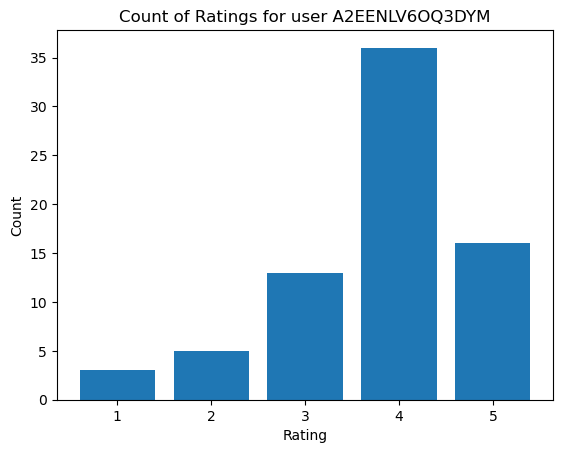

In [7]:
plot_ratings_for_user(selected_user_id, ratings_by_reviewer)

## Deciding how we will test



In [8]:
# Portion we want to leave to test our models
test_portion = 0.1

RESULTS_BY_DIMENSION_ISO_MAP_FIXED_BETA = {}
regrets_for_ISOMAP_fixed_beta = []
labels_for_ISOMAP_fixed_beta = []
RESULTS_BY_DIMENSION_ISO_MAP_INCREASING_BETA = {}
regrets_for_ISOMAP_increasing_beta = []
labels_for_ISOMAP_increasing_beta = []

RESULTS_BY_DIMENSION_PCA_FIXED_BETA = {}
regrets_for_PCA_fixed_beta = []
labels_for_PCA_fixed_beta = []
RESULTS_BY_DIMENSION_PCA_INCREASING_BETA = {}
regrets_for_PCA_increasing_beta = []
labels_for_PCA_increasing_beta = []

In [9]:
# Separating training and test data
ratings_by_reviewer_training, ratings_by_reviewer_test = separate_training_test_data(ratings_by_reviewer, test_portion)

### Linear UCB for ISOMAP with fixed beta

In [10]:
n_simulations = 50
n_rounds = 500
max_reward = 5
noise = 0.0
lambda_param = 0.1

# Running the algorithm for a given user
RESULTS_BY_DIMENSION_ISO_MAP_FIXED_BETA = train_linear_ucb_for_one_user_all_dimensions(ISOMAP_BY_DIMENSION, ratings_by_reviewer_training, selected_user_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=True, beta_value=2.0)

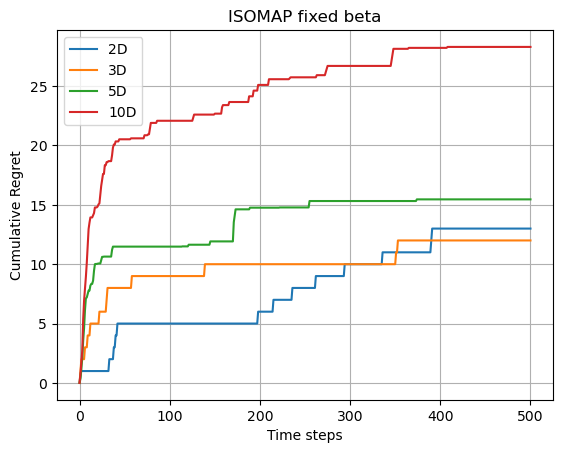

In [11]:
# Plotting of a given user
regrets_for_ISOMAP_fixed_beta = [t[0] for t in RESULTS_BY_DIMENSION_ISO_MAP_FIXED_BETA.values()] 
labels_for_ISOMAP_fixed_beta = [str(key) + 'D' for key in ISOMAP_PATHS_BY_DIMENSION.keys()]

plot_multiple_lines(regrets_for_ISOMAP_fixed_beta, labels_for_ISOMAP_fixed_beta, 'ISOMAP fixed beta', "Time steps", "Cumulative Regret")

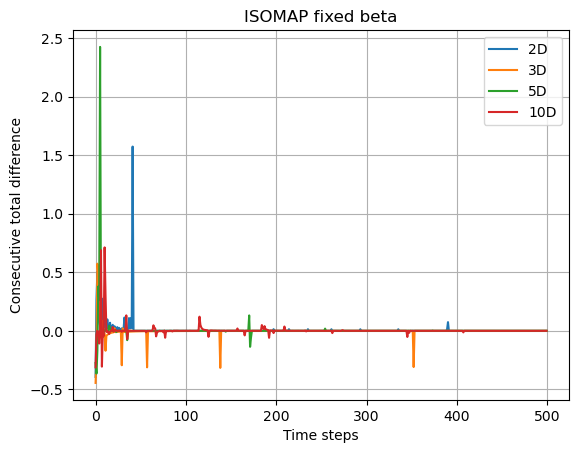

In [12]:
diffs_for_ISOMAP = []
labels_for_ISOMAP = [str(key) + 'D' for key in ISOMAP_PATHS_BY_DIMENSION.keys()]

for key in ISOMAP_BY_DIMENSION:
    avg_curr_all_theta_hat = RESULTS_BY_DIMENSION_ISO_MAP_FIXED_BETA[key][1]
    # Make the array collapse and sum
    sum_array = np.sum(avg_curr_all_theta_hat, axis=0)
    # Compute the differences between consecutive elements
    diff = np.diff(sum_array)
    diffs_for_ISOMAP.append(diff)

plot_multiple_lines(diffs_for_ISOMAP, labels_for_ISOMAP, 'ISOMAP fixed beta', "Time steps", "Consecutive total difference")

On the graph above, you can see the consecutive difference (sum of absolute differences every element in the estimated feature vector between each consecutive time step)

At the end of a run, we have the average theta hat at the end of the simulations for a particular user, with this, we can calculate its dot product with the arm it chooses next and we can find the absolute difference between the estimated reward and the true reward.

### Linear UCB for ISOMAP with logarithmic increasing beta

In [13]:
RESULTS_BY_DIMENSION_ISO_MAP_INCREASING_BETA = train_linear_ucb_for_one_user_all_dimensions(ISOMAP_BY_DIMENSION, ratings_by_reviewer_training, selected_user_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=False, beta_value=8.0)


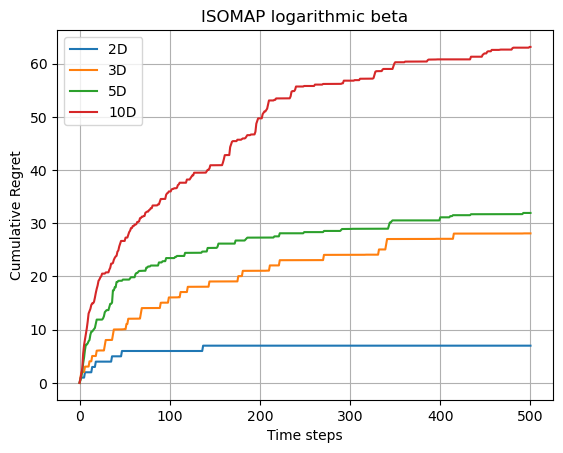

In [14]:
regrets_for_ISOMAP_increasing_beta = [t[0] for t in RESULTS_BY_DIMENSION_ISO_MAP_INCREASING_BETA.values()] 
labels_for_ISOMAP_increasing_beta = [str(key) + 'D' for key in ISOMAP_PATHS_BY_DIMENSION.keys()]
 
plot_multiple_lines(regrets_for_ISOMAP_increasing_beta, labels_for_ISOMAP_increasing_beta, 'ISOMAP logarithmic beta', "Time steps", "Cumulative Regret")

In [15]:
diffs_for_ISOMAP = []
labels_for_ISOMAP = [str(key) + 'D' for key in ISOMAP_PATHS_BY_DIMENSION.keys()]

for key in ISOMAP_BY_DIMENSION:
    avg_curr_all_theta_hat = RESULTS_BY_DIMENSION_ISO_MAP_INCREASING_BETA[key][1]
    # Make the array collapse and sum
    sum_array = np.sum(avg_curr_all_theta_hat, axis=0)
    # Compute the differences between consecutive elements
    diff = np.diff(sum_array)
    
    diffs_for_ISOMAP.append(diff)

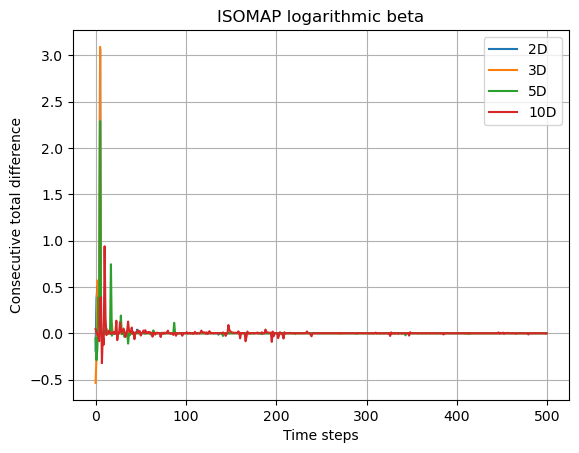

In [16]:

plot_multiple_lines(diffs_for_ISOMAP, labels_for_ISOMAP, 'ISOMAP logarithmic beta', "Time steps", "Consecutive total difference")

### Linear UCB for PCA with fixed beta

In [17]:
RESULTS_BY_DIMENSION_PCA_FIXED_BETA = train_linear_ucb_for_one_user_all_dimensions(PCA_BY_DIMENSION, ratings_by_reviewer_training, selected_user_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=True, beta_value=2.0)


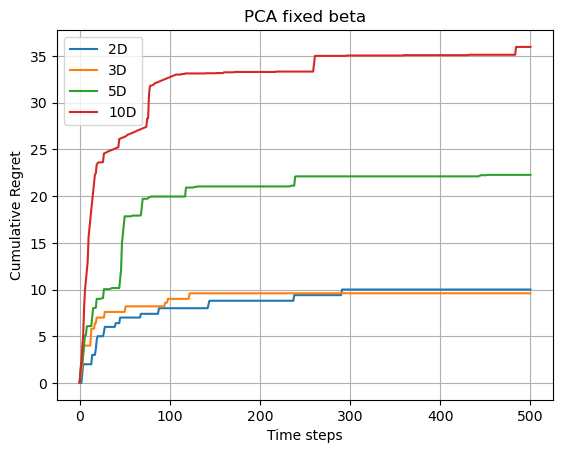

In [18]:
regrets_for_PCA_FIXED_BETA = [t[0] for t in RESULTS_BY_DIMENSION_PCA_FIXED_BETA.values()] 
labels_for_PCA_FIXED_BETA = [str(key) + 'D' for key in PCA_PATHS_BY_DIMENSION.keys()]
 
plot_multiple_lines(regrets_for_PCA_FIXED_BETA, labels_for_PCA_FIXED_BETA, 'PCA fixed beta', "Time steps", "Cumulative Regret")

In [19]:
diffs_for_PCA = []
labels_for_PCA = [str(key) + 'D' for key in PCA_PATHS_BY_DIMENSION.keys()]

for key in PCA_BY_DIMENSION:
    avg_curr_all_theta_hat = RESULTS_BY_DIMENSION_PCA_FIXED_BETA[key][1]
    # Make the array collapse and sum
    sum_array = np.sum(avg_curr_all_theta_hat, axis=0)
    # Compute the differences between consecutive elements
    diff = np.diff(sum_array)
    
    diffs_for_PCA.append(diff)

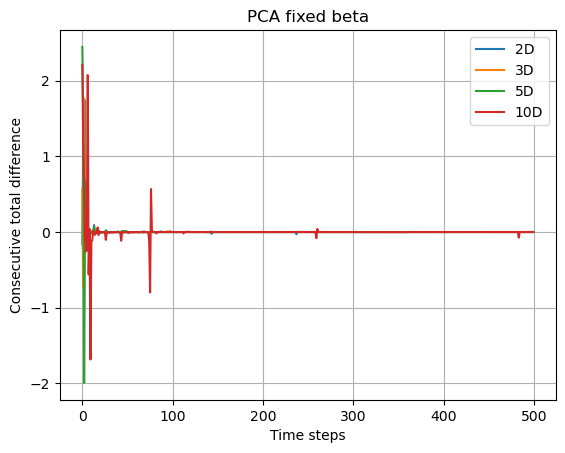

In [20]:

plot_multiple_lines(diffs_for_PCA, labels_for_PCA, 'PCA fixed beta', "Time steps", "Consecutive total difference")

### Linear UCB for PCA with logarithmic increasing beta

In [21]:
RESULTS_BY_DIMENSION_PCA_INCREASING_BETA = train_linear_ucb_for_one_user_all_dimensions(PCA_BY_DIMENSION, ratings_by_reviewer_training, selected_user_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=False, beta_value=4.0)


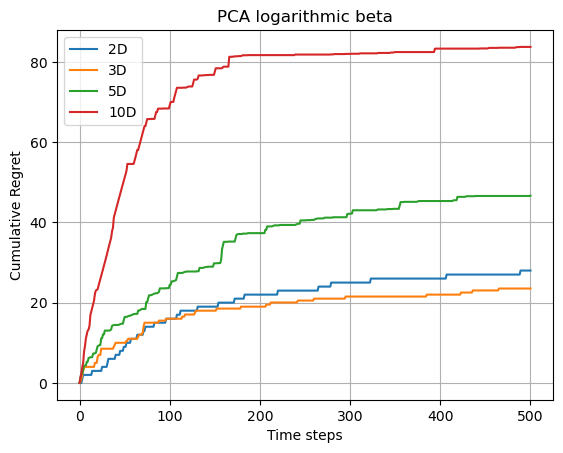

In [22]:
regrets_for_PCA_INCREASING_BETA = [t[0] for t in RESULTS_BY_DIMENSION_PCA_INCREASING_BETA.values()] 
labels_for_PCA_INCREASING_BETA = [str(key) + 'D' for key in PCA_PATHS_BY_DIMENSION.keys()]
 
plot_multiple_lines(regrets_for_PCA_INCREASING_BETA, labels_for_PCA_INCREASING_BETA, 'PCA logarithmic beta', "Time steps", "Cumulative Regret")

In [23]:
diffs_for_PCA = []
labels_for_PCA = [str(key) + 'D' for key in PCA_PATHS_BY_DIMENSION.keys()]

for key in PCA_BY_DIMENSION:
    avg_curr_all_theta_hat = RESULTS_BY_DIMENSION_PCA_INCREASING_BETA[key][1]
    # Make the array collapse and sum
    sum_array = np.sum(avg_curr_all_theta_hat, axis=0)
    # Compute the differences between consecutive elements
    diff = np.diff(sum_array)
    
    diffs_for_PCA.append(diff)

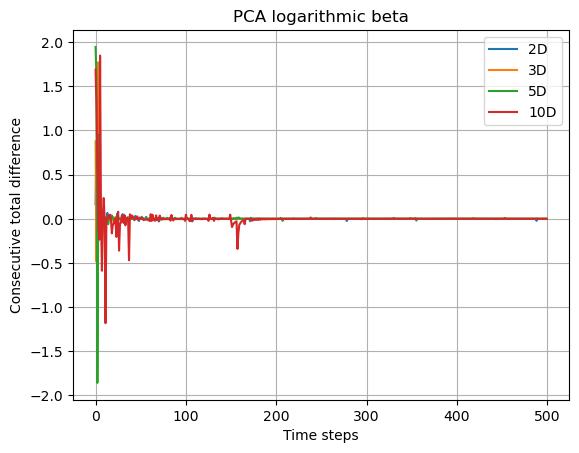

In [24]:

plot_multiple_lines(diffs_for_PCA, labels_for_PCA, 'PCA logarithmic beta', "Time steps", "Consecutive total difference")

# Simulating on all users and testing linear ucb

## Preparing the inputs

In [4]:
test_portion = 0.1
# Separating training and test data
ratings_by_reviewer_training, ratings_by_reviewer_test = separate_training_test_data(ratings_by_reviewer, test_portion)

In [6]:
n_simulations = 2
n_rounds = 500
max_reward = 5
noise = 0.0
lambda_param = 0.1

## Finding out the optimal beta

In order to do that, we will only look at the graph of average differences for multiple values of beta (fixed). Then we will proceed to do the same for an logarithmically increasing beta.

In [7]:
beta_values = [2.0, 5.0, 8.0, 10.0, 15.0]

### ISOMAP with fixed beta

In [8]:
avg_regrets_by_dim, avg_diff_by_dim = simulation_on_all_users_all_dimensions(ISOMAP_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, True, beta_values)
# np.save('isomap_fixed_beta_diffs.npy', (avg_regrets_by_dim, avg_diff_by_dim))

# avg_regrets_by_dim, avg_diff_by_dim = np.load('./saved-data/isomap_fixed_beta_diffs.npy', allow_pickle=True)

NameError: name 'simulation_on_all_users_all_dimensions' is not defined

In [9]:
# Plot

list_of_dict = avg_diff_by_dim
list_of_labels = list_of_labels_from_values_list(beta_values, "beta : ")
plot_dict_list(list_of_dict, "Dimensions", "Absolute difference", "Fixed Beta variations for ISOMAP", list_of_labels)



NameError: name 'avg_diff_by_dim' is not defined

### ISOMAP with increasing beta

In [23]:
# avg_regrets_by_dim, avg_diff_by_dim = simulation_on_all_users_all_dimensions(ISOMAP_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, False, beta_values)
# np.save('isomap_increasing_beta_diffs.npy', (avg_regrets_by_dim, avg_diff_by_dim))

avg_regrets_by_dim, avg_diff_by_dim = np.load('./saved-data/isomap_increasing_beta_diffs.npy', allow_pickle=True)


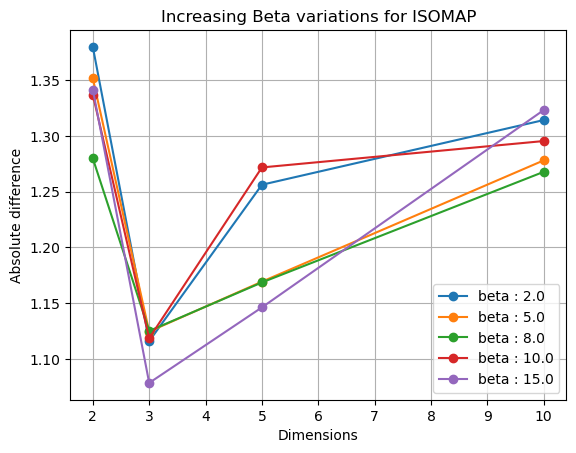

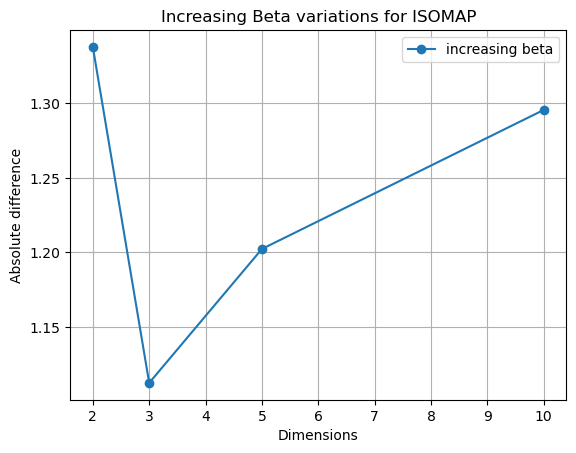

In [24]:
# Plot
list_of_dict = avg_diff_by_dim
list_of_labels = list_of_labels_from_values_list(beta_values, "beta : ")
plot_dict_list(list_of_dict, "Dimensions", "Absolute difference", "Increasing Beta variations for ISOMAP", list_of_labels)

# When beta is increasing, the beta value given does not matter since it only depends on the round
# Therefore we can average it:

total_avg_diff = {}
for dic in avg_diff_by_dim:
    for key in dic:
        if key in total_avg_diff:
            total_avg_diff[key] += dic[key]
        else:
            total_avg_diff[key] = dic[key]

for key in total_avg_diff:
    total_avg_diff[key] = total_avg_diff[key] / len(avg_diff_by_dim)

plot_dict_list([total_avg_diff], "Dimensions", "Absolute difference", "Increasing Beta variations for ISOMAP", ["increasing beta"])

### PCA with fixed beta

In [25]:
# avg_regrets_by_dim, avg_diff_by_dim = simulation_on_all_users_all_dimensions(PCA_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, True, beta_values)
# np.save('pca_fixed_beta_diffs.npy', (avg_regrets_by_dim, avg_diff_by_dim))

avg_regrets_by_dim, avg_diff_by_dim = np.load('./saved-data/pca_fixed_beta_diffs.npy', allow_pickle=True)

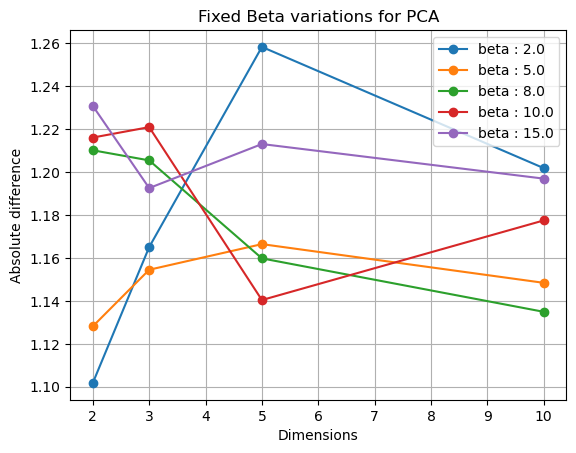

In [26]:
# Plot
list_of_dict = avg_diff_by_dim
list_of_labels = list_of_labels_from_values_list(beta_values, "beta : ")
plot_dict_list(list_of_dict, "Dimensions", "Absolute difference", "Fixed Beta variations for PCA", list_of_labels)


### PCA with increasing beta

In [27]:
# avg_regrets_by_dim, avg_diff_by_dim = simulation_on_all_users_all_dimensions(PCA_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, False, beta_values)
# np.save('pca_increasing_beta_diffs.npy', (avg_regrets_by_dim, avg_diff_by_dim))

avg_regrets_by_dim, avg_diff_by_dim = np.load('./saved-data/pca_increasing_beta_diffs.npy', allow_pickle=True)


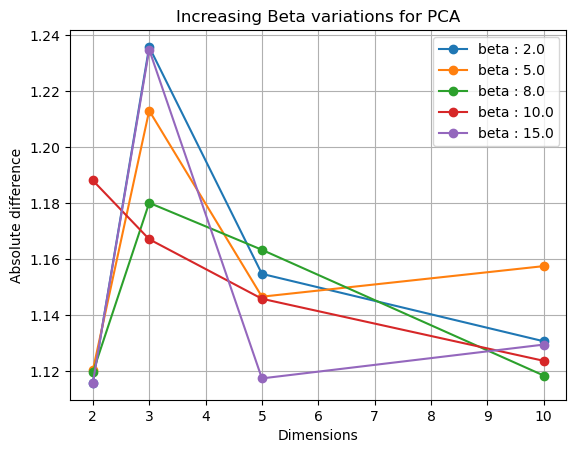

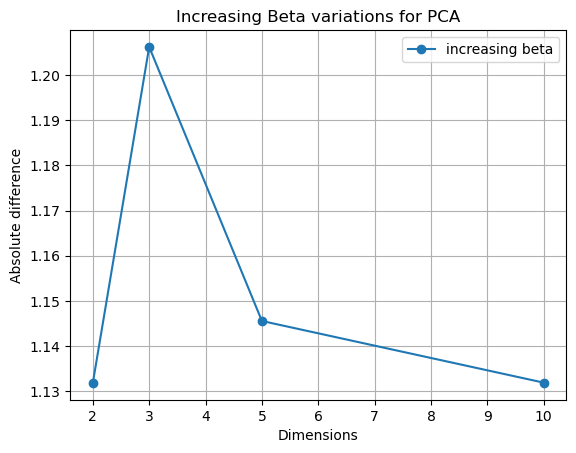

In [28]:
# Plot
list_of_dict = avg_diff_by_dim
list_of_labels = list_of_labels_from_values_list(beta_values, "beta : ")
plot_dict_list(list_of_dict, "Dimensions", "Absolute difference", "Increasing Beta variations for PCA", list_of_labels)

# When beta is increasing, the beta value given does not matter since it only depends on the round
# Therefore we can average it:

total_avg_diff = {}
for dic in avg_diff_by_dim:
    for key in dic:
        if key in total_avg_diff:
            total_avg_diff[key] += dic[key]
        else:
            total_avg_diff[key] = dic[key]

for key in total_avg_diff:
    total_avg_diff[key] = total_avg_diff[key] / len(avg_diff_by_dim)

plot_dict_list([total_avg_diff], "Dimensions", "Absolute difference", "Increasing Beta variations for PCA", ["increasing beta"])

## Discussion of results :

We discover that the best value of beta depends ...

## Plotting the average differences for ISOMAP and PCA with both fixed beta and increasing beta 
We are running this experiment with a good beta found from the previous part

In [ ]:
beta_values = [8.0]
n_simulations = 6


In [ ]:
avg_regrets_by_dim_isomap_fixed_beta, avg_diff_by_dim_isomap_fixed_beta = simulation_on_all_users_all_dimensions(ISOMAP_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, True, beta_values)

In [ ]:
avg_regrets_by_dim_isomap_increasing_beta, avg_diff_by_dim_isomap_increasing_beta = simulation_on_all_users_all_dimensions(ISOMAP_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, False, beta_values)

In [ ]:
avg_regrets_by_dim_pca_fixed_beta, avg_diff_by_dim_pca_fixed_beta = simulation_on_all_users_all_dimensions(PCA_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, True, beta_values)

In [ ]:
avg_regrets_by_dim_pca_increasing_beta, avg_diff_by_dim_pca_increasing_beta = simulation_on_all_users_all_dimensions(PCA_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, False, beta_values)

In [ ]:
# Preparing to plot everything
list_of_dict = []
list_of_labels = [] 

list_of_dict.append(avg_diff_by_dim_isomap_fixed_beta[0])
list_of_labels.append("ISOMAP fixed beta")

list_of_dict.append(avg_diff_by_dim_isomap_increasing_beta[0])
list_of_labels.append("ISOMAP increasing beta")

list_of_dict.append(avg_diff_by_dim_pca_fixed_beta[0])
list_of_labels.append("PCA fixed beta")

list_of_dict.append(avg_diff_by_dim_pca_increasing_beta[0])
list_of_labels.append("PCA increasing beta")


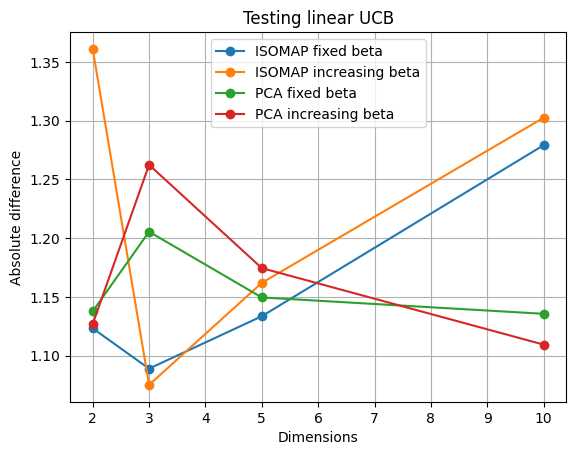

In [ ]:
plot_dict_list(list_of_dict, "Dimensions", "Absolute difference", "Testing linear UCB", list_of_labels)